In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Identity for single site
id3 = np.eye(3)

# Define x^{(±)}_{i,alpha}
x_matrices = {
    ('+', 1): np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]]),
    ('-', 1): np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]]),
    ('+', 2): np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]]),
    ('-', 2): np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]),
}

# Define T^{(±)}_{k,alpha,beta}
T_matrices = {
    ('+', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('-', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('+', 1, 2): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('-', 1, 2): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('+', 2, 1): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('-', 2, 1): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('+', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
    ('-', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
}

def build_paraparticle_operator(N, site_index, alpha, sign):
    assert 1 <= site_index <= N
    assert alpha in [1, 2]
    assert sign in ['+', '-']

    total_op = np.zeros((3**N, 3**N))

    # Generate all beta chains of length (site_index - 1)
    for beta_chain in product([1, 2], repeat=site_index - 1):
        op_list = []

        # Construct the x^{(sign)}_{i,beta_{i-1}} part
        beta_prev = beta_chain[-1] if beta_chain else alpha
        x_op = x_matrices[(sign, beta_prev)]
        op_list.append(x_op)

        # Build T^{(sign)} chain in reverse site order
        for k in reversed(range(site_index - 1)):
            beta_k = beta_chain[k]
            beta_k_minus_1 = alpha if k == 0 else beta_chain[k - 1]
            T_k = T_matrices[(sign, beta_k_minus_1, beta_k)]
            op_list.insert(0, T_k)  # prepend

        # Pad identity operators
        full_op_list = (
            [id3] * (site_index - len(op_list)) + op_list + [id3] * (N - site_index)
        )

        # Compute full Kronecker product
        kron_op = full_op_list[0]
        for m in range(1, len(full_op_list)):
            kron_op = np.kron(kron_op, full_op_list[m])

        total_op += kron_op

    return total_op


def construct_site_paraparticle_number_operator(N, site_index):
    assert 1 <= site_index <= N
    n_i = np.zeros((3**N, 3**N))

    for alpha in [1, 2]:
        psi_plus = build_paraparticle_operator(N, site_index, alpha, '+')
        psi_minus = build_paraparticle_operator(N, site_index, alpha, '-')
        n_i += psi_plus @ psi_minus

    return n_i

def construct_total_paraparticle_number_operator(N):
    total_n = np.zeros((3**N, 3**N))
    for i in range(1, N + 1):
        total_n += construct_site_paraparticle_number_operator(N, i)
    return total_n

def exact_diagonalize_with_total_paraparticle_number_symmetry(hamiltonian, total_paraparticle_number_operator):
    """
    Diagonalizes a Hamiltonian within symmetry sectors defined by the total paraparticle number operator.
    
    Args:
        hamiltonian (np.ndarray): The Hamiltonian matrix.
        total_paraparticle_number_operator (np.ndarray): The symmetry operator (should commute with H).
    
    Returns:
        eigenvalues (np.ndarray): 1D array of all eigenvalues.
        eigenvectors (list of np.ndarray): List of eigenvectors (each is 1D, in original basis).
        total_paraparticle_numbers (np.ndarray): Expectation values of total paraparticle number in each eigenstate.
    """
    # Diagonalize the symmetry operator
    eigvals_symm, V_N = np.linalg.eigh(total_paraparticle_number_operator)

    # Rotate Hamiltonian into symmetry eigenbasis
    number_basis_ham = V_N.conj().T @ hamiltonian @ V_N

    # Identify unique symmetry sectors
    unique_sectors = np.unique(np.round(eigvals_symm, decimals=10))  # rounded for numerical stability
    sector_indices = {
        sector: np.where(np.isclose(eigvals_symm, sector, atol=1e-10))[0]
        for sector in unique_sectors
    }

    # Diagonalize each symmetry sector
    sector_eigenvalues = {}
    sector_eigenvectors = {}
    for sector, indices in sector_indices.items():
        block = number_basis_ham[np.ix_(indices, indices)]
        e_vals, e_vecs = np.linalg.eigh(block)
        sector_eigenvalues[sector] = e_vals
        sector_eigenvectors[sector] = e_vecs

    # Construct full eigenvectors in symmetry basis
    dim = hamiltonian.shape[0]
    full_symm_evecs = np.zeros((dim, dim), dtype=complex)
    for sector, indices in sector_indices.items():
        block_evecs = sector_eigenvectors[sector]
        idx = np.ix_(indices, indices)
        full_symm_evecs[idx] = block_evecs

    # Rotate back to original basis
    full_eigenvectors = V_N @ full_symm_evecs

    # Gather eigenvalues and eigenvectors
    full_eigenvalues = np.concatenate([sector_eigenvalues[sector] for sector in unique_sectors])
    eigenvectors = [full_eigenvectors[:, i] for i in range(full_eigenvectors.shape[1])]

    # Compute total paraparticle number in each eigenstate
    total_ns = [
        np.real_if_close(vec.conj().T @ total_paraparticle_number_operator @ vec)
        for vec in eigenvectors
    ]

    return full_eigenvalues, eigenvectors, np.array(total_ns)


In [3]:
N = 3
M = 3
V = 1

times = np.linspace(0, 500, 5000)
initial_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
quench_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 3)

hamiltonians = [initial_hamiltonian] + [quench_hamiltonian] * (len(times) - 1)
total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)

eigenvalues, eigenvectors, total_ns = exact_diagonalize_with_total_paraparticle_number_symmetry(initial_hamiltonian, total_paraparticle_number_operator)
initial_state = eigenvectors[1]

results = simulate_hamiltonian_time_evolution(hamiltonians, times, initial_state)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = results


Text(0, 0.5, 'Total Paraparticle Number')

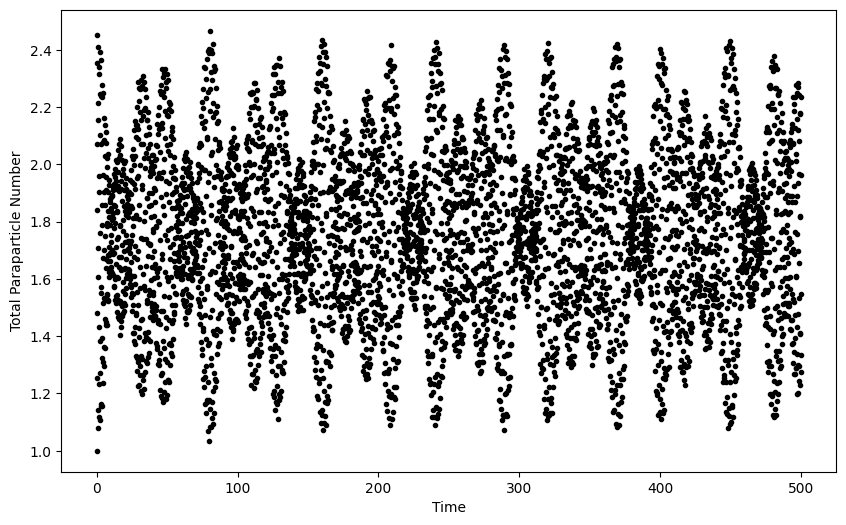

In [4]:
fig, ax  = plt.subplots(figsize=(10, 6))


for i, wavefunction in enumerate(time_evolved_wavefunctions):
    paraparticle_number = wavefunction.conj().T @ total_paraparticle_number_operator @ wavefunction
    ax.plot(times[i], paraparticle_number, '.k')

ax.set_xlabel('Time')
ax.set_ylabel('Total Paraparticle Number')

In [5]:
N = 5
M = 3
V = 1

total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
initial_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
eigenvalues, eigenvectors, total_ns = exact_diagonalize_with_total_paraparticle_number_symmetry(initial_hamiltonian, total_paraparticle_number_operator)

perturb_hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0.1)
times = np.linspace(0, 1000, 1000)
hamiltonians = [perturb_hamiltonian for t in times]

initial_state = eigenvectors[0]

results = simulate_hamiltonian_time_evolution(hamiltonians, times, initial_state)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies, ground_state_manifold_overlaps = results

exp_values = []
for state in time_evolved_wavefunctions:
    exp_values += [state.conj().T @ total_paraparticle_number_operator @ state]

KeyboardInterrupt: 

Text(0.5, 0, 't')

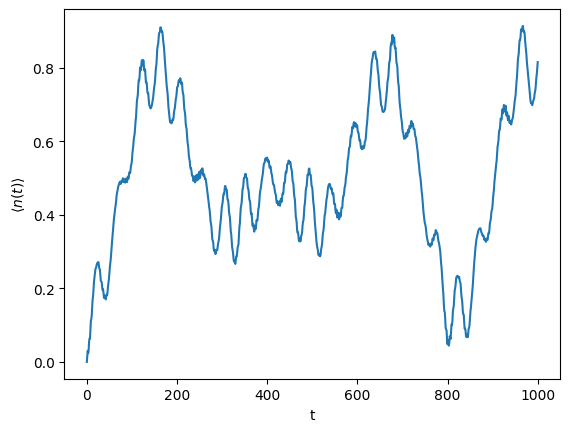

In [ ]:
fig, ax = plt.subplots()
ax.plot(times, exp_values, '-')
ax.set_ylabel("$\langle n (t) \\rangle$")
ax.set_xlabel("t")


In [ ]:
N = 2
M = 3
V = 1

total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)

test_hamiltonian = construct_hamiltonian(N, M, V = 1, mu = 0, J = 0)
print(np.real(np.array(test_hamiltonian)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
eigenvalues, eigenvectors, total_ns = exact_diagonalize_with_total_paraparticle_number_symmetry(test_hamiltonian, total_paraparticle_number_operator)

In [10]:
N = 7
total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
print(np.shape(total_paraparticle_number_operator))

(2187, 2187)


In [ ]:
def build_paraparticle_operator(N, site_index, alpha, sign):
    assert 1 <= site_index <= N
    assert alpha in [1, 2]
    assert sign in ['+', '-']

    total_op = np.zeros((3**N, 3**N))

    # generate all beta chains of length (site_index - 1)
    for beta_chain in product([1, 2], repeat=site_index - 1):
        op_list = []

        # construct the x^{(sign)}_{i,beta_{i-1}} part
        beta_prev = beta_chain[-1] if beta_chain else alpha
        x_op = x_matrices[(sign, beta_prev)]
        op_list.append(x_op)

        # build T^{(sign)} chain in reverse site order
        for k in reversed(range(site_index - 1)):
            beta_k = beta_chain[k]
            beta_k_minus_1 = alpha if k == 0 else beta_chain[k - 1]
            T_k = T_matrices[(sign, beta_k_minus_1, beta_k)]
            op_list.insert(0, T_k)  # prepend

        # pad identity operators
        full_op_list = (
            [id3] * (site_index - len(op_list)) + op_list + [id3] * (N - site_index)
        )

        # compute full tensor product
        kron_op = full_op_list[0]
        for m in range(1, len(full_op_list)):
            kron_op = np.kron(kron_op, full_op_list[m])

        total_op += kron_op

    return total_op


def construct_site_paraparticle_number_operator(N, site_index):
    assert 1 <= site_index <= N
    n_i = np.zeros((3**N, 3**N))

    for alpha in [1, 2]:
        psi_plus = build_paraparticle_operator(N, site_index, alpha, '+')
        psi_minus = build_paraparticle_operator(N, site_index, alpha, '-')
        n_i += psi_plus @ psi_minus

    return n_i

def construct_total_paraparticle_number_operator(N):
    total_n = np.zeros((3**N, 3**N))
    for i in range(1, N + 1):
        total_n += construct_site_paraparticle_number_operator(N, i)
    return total_n